# ALeRCE light curve classifier
Author: Ignacio Reyes, Last updated: 10/08/2021
### **Notebook under development**

## Table of contents:
* [Required libraries](#Required-libraries)
* [The classifier](#The-classifier)
    * [Brief explanation of the data](#Brief-explanation-of-the-data)
    * [Model description](#Model-description)
    * [Results](#Results)
    * [ALeRCE Explorer](#ALeRCE-Explorer)
* [Query model predictions](#Query-model-predictions)
    * [Which objects have we found?](#Which-objects-have-we-found?)
* [Spatial distribution of the predictions](#Spatial-distribution-of-the-predictions)
    * [Galactic sources](#Galactic-sources-(LPV,-CEP,-YSO))
    * [Extragalactic sources](#Extragalactic-sources-(QSO,-AGN,-Blazar,-SNe))
* [Visualizing a sample of predicted objects](#Visualizing-a-sample-of-predicted-objects)

## Required libraries

In [1]:
!pip install alerce

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alerce.core import Alerce
import psycopg2
import json

# The classifier
This notebook shows the light curve classifier from ALeRCE, described in detail in "Alert Classification for the ALeRCE Broker System: The Light Curve Classifier" by Sánchez-Sáez et. al (2020, under review). The goal of this notebook is to show how to access the predictions made by the model from ALeRCE's database. The code to replicate the results from the paper is contained in another GitHub repository.

## Brief explanation of the data
ALeRCE's database contains all the alerts generated by the Zwicky Transient Facility (ZTF) public stream. An alert is generated by ZTF each time an area of the sky is observed and a difference in brightness is detected. All alerts from the same coordinates are grouped into the same object with an object id (oid). Up to this date, the database contains more than 100 million alerts and 35 million objects.

Most ZTF detections come from two filters, g and r. Let's see an example of a light curve from ZTF.

In [5]:
alerce_client = Alerce()

In [6]:
def plot_light_curve(df, title='', period=None):
    def colormap(i):
        if i == 1:
            return '#56e03a'
        elif i == 2:
            return '#d42f4b'
        else:
            return '#000000'
    for fid in [1, 2]:
        fid_df = df[df.fid == fid]
        if len(fid_df) == 0:
            continue
        if period is not None:
            mjd = (fid_df.mjd % period) / period
        else:
            mjd = fid_df.mjd
        plt.errorbar(
            mjd,
            fid_df.magpsf,
            yerr=fid_df.sigmapsf,
            fmt='*',
            c=colormap(fid))
    plt.gca().invert_yaxis()
    if period is not None:
        plt.xlabel(f'Phase (period={period:.3f})')
    else:
        plt.xlabel('Date [mjd]')
    plt.ylabel('Apparent magnitude [mag]')
    plt.title(title)

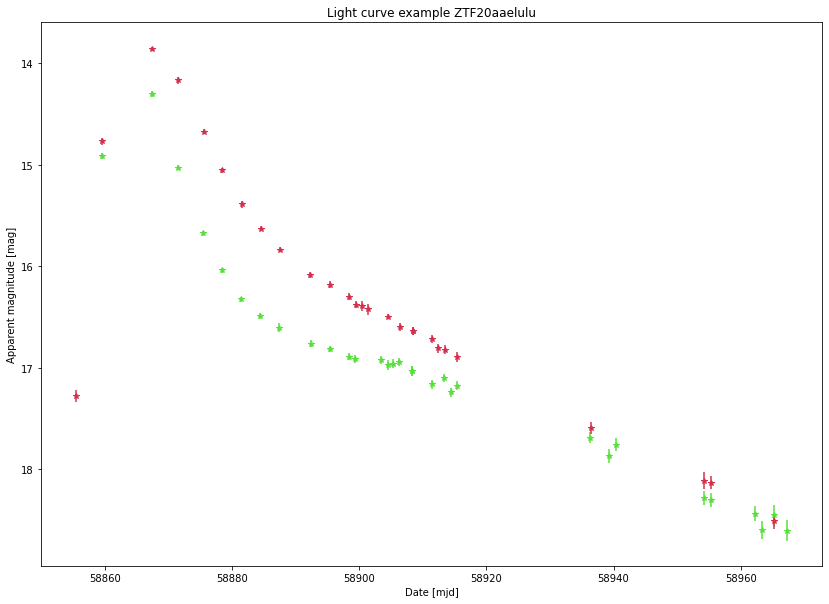

In [7]:
fig = plt.figure(figsize=(14, 10))
fig.patch.set_facecolor('white')
oid = 'ZTF20aaelulu'
light_curve = alerce_client.query_detections(oid, format='pandas')
plot_light_curve(light_curve, title=f'Light curve example {oid}')


The training set for the light curve classifier was built by cross matching ZTF with many astronomical catalogs with objects from known categories. The current training set of ALeRCE contains more than 1700 supernovae from many subclasses, almost 35k stochastic sources (QSO, AGN, Blazar, YSO, CV/Nova) and 87k light curves from periodic stars.

## Model description
When a light curve has more than 5 alerts in any of its bands it's classified by our light curve classifier. The model uses Machine Learning, combining feature extraction of the light curves and a model build of 4 Random Forest classifiers. Each object is classified in 15 astrophysical categories according to the following taxonomy.

![ALeRCE_taxonomy](colab/figures/ml/taxonomy.png)

Our classifier takes the light curve of an object, information about non-detections (previous ZTF observations where no alerts were generated), the metadata available from ZTF (e.g. coordinates) and cross match data from WISE if available. Using that data, more than 150 features are computed.

Some of the computed features are:
* Irregular autoregressive model from Eyheramendy et al. (2018).
* Mexican hat power spectrum from Arévalo et al. (2012).
* Parameters from a damped random walk model from Graham et al. (2017).
* Structure function from Schmidt et al. (2010).
* Multiband periodogram from Mondrik et al. (2015).

Once the features are computed they are classified by 4 Random Forest models, grouped in a hierarchy with two levels. The random forest on the top level classifies each object into 3 main categories: stochastic, transient and periodic sources. After that, each object is processed by 3 random forest classifiers in the bottom level, each one specialized in one category of objects.

For example, the Transient Random Forest provides as output a vector with 4 probabilities, which corresponds to the probability of being a SN type Ia, SN type Ibc, SN type II or superluminous supernova.

Finally, the outputs of the 4 classsifiers are combined using the total probabilities rule. That means that the probability of an object being a cepheid according to our classifier is the product of the object being a periodic star (computed by the random forest of the top level) and the probability of the object being a cepheid (computed by the periodic random forest).

![Hierarchical_Random_Forest](colab/figures/ml/hierarchical_rf.png)

## Results

The following confusion matrix is a summary of the performance of the model over the test set. This figure shows that the classifier is able to separate among the different classes. Of course some classes are difficult to distinguish, but the mistakes are "reasonable" in the sense that most of them choose a similar class. For example, most misclassified supernovae type Ia are labeled as another kind of supernova.

The black boxes in the figure indicate the confusion inside of one of the three main categories: transient sources, periodic stars and stochastic objects.
![Confusion_matrix](colab/figures/ml/sanchez_paper_confusion_matrix.png)

## ALeRCE Explorer
All the data in ALeRCE's database, including model predictions, can be seen using the ALeRCE Explorer. The explorer is available in https://alerce.online

This webpage is currently being updated, so the shown predictions can be out of date.

![ALeRCE_Explorer](colab/figures/ml/alerce_explorer.png)

Once an object is selected, all available information about it is shown. The figure in the bottom center shows the probabilities given by the light curve classifier.

![alerce_explorer_object](colab/figures/ml/alerce_explorer_object.png)

In [154]:
!wget https://github.com/alercebroker/usecases/raw/master/alercereaduser_v4.json
!mv alercereaduser_v4.json ..
credentials_file = "../alercereaduser_v4.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]
conn = psycopg2.connect(
    dbname=params['dbname'], 
    user=params['user'], 
    host=params['host'], 
    password=params['password'])

--2022-05-06 14:44:12--  https://github.com/alercebroker/usecases/raw/master/alercereaduser_v4.json
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json [following]
--2022-05-06 14:44:12--  https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156 [text/plain]
Saving to: ‘alercereaduser_v4.json’

alercereaduser_v4.j 100%[===================>]     156  --.-KB/s    in 0s      

2022-05-06 14:44:13 (6.33 MB/s) - ‘alercereaduser_v4.json’ saved [156/156]



In [55]:
query = "SELECT tablename FROM pg_tables"
tabs = pd.read_sql_query(query, conn)
str(list(tabs['tablename']))

"['outlier', 'feature_version', 'gaia_ztf', 'ps1_ztf', 'ss_ztf', 'allwise', 'xmatch', 'taxonomy', 'pg_statistic', 'pg_type', 'feature', 'step', 'pg_foreign_table', 'pg_authid', 'non_detection', 'detection', 'magstat', 'pg_statistic_ext_data', 'lc_classifier', 'reference', 'pipeline', 'pg_largeobject', 'dataquality', 'pg_user_mapping', 'pg_subscription', 'pg_attribute', 'pg_proc', 'pg_class', 'pg_attrdef', 'pg_constraint', 'pg_inherits', 'pg_index', 'pg_operator', 'pg_opfamily', 'pg_opclass', 'pg_am', 'pg_amop', 'pg_amproc', 'pg_language', 'pg_largeobject_metadata', 'pg_aggregate', 'pg_statistic_ext', 'pg_rewrite', 'pg_trigger', 'pg_event_trigger', 'pg_description', 'pg_cast', 'pg_enum', 'pg_namespace', 'pg_conversion', 'pg_depend', 'pg_database', 'pg_db_role_setting', 'pg_tablespace', 'pg_auth_members', 'pg_shdepend', 'pg_shdescription', 'pg_ts_config', 'pg_ts_config_map', 'pg_ts_dict', 'pg_ts_parser', 'pg_ts_template', 'pg_extension', 'pg_foreign_data_wrapper', 'pg_foreign_server', 'p

In [94]:
query = "SELECT * FROM probability WHERE oid = 'ZTF19aargvet'"
tabs = pd.read_sql_query(query, conn)
tabs[tabs['probability']>0.5]

,oid,classifier_name,classifier_version,class_name,probability,ranking
6,ZTF19aargvet,lc_classifier,hierarchical_rf_1.1.0,LPV,0.976140,1
18,ZTF19aargvet,lc_classifier_periodic,hierarchical_rf_1.1.0,LPV,0.986000,1
25,ZTF19aargvet,lc_classifier_stochastic,hierarchical_rf_1.1.0,YSO,0.848000,1
26,ZTF19aargvet,lc_classifier_top,hierarchical_rf_1.1.0,Periodic,0.990000,1
37,ZTF19aargvet,stamp_classifier,stamp_classifier_1.0.0,VS,0.815075,1
42,ZTF19aargvet,stamp_classifier,stamp_classifier_1.0.4,VS,0.575152,1


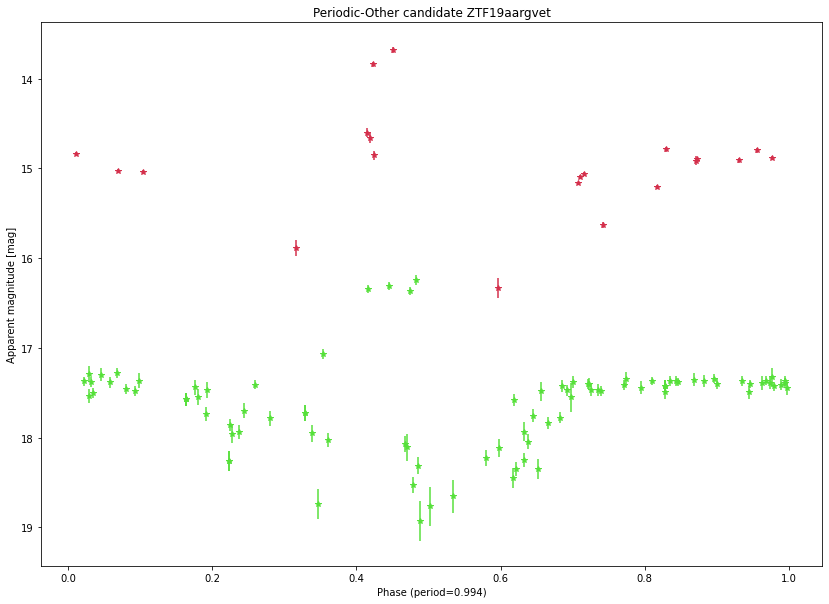

In [93]:
oid = 'ZTF19aargvet'

query = f"select oid, name, value from feature where name = 'Multiband_period' and oid = '{oid}';"
period_df = pd.read_sql_query(query, conn)
if len(period_df) > 0:
    period = float(period_df.value.values[0])

    
fig = plt.figure(figsize=(14, 10))
fig.patch.set_facecolor('white')
light_curve = alerce_client.query_detections(oid, format='pandas')
plot_light_curve(light_curve, title=f'{astro_class} candidate {oid}', period=period)

In [9]:
# Heavy query (~ 2 min)
query = "select * from probability where classifier_name = 'lc_classifier' and ranking = 1;"
bhrf_predictions = pd.read_sql_query(query, conn)
bhrf_predictions

,oid,classifier_name,classifier_version,class_name,probability,ranking
0,ZTF18aadcbyv,lc_classifier,hierarchical_rf_1.1.0,YSO,0.389424,1
1,ZTF20acrcfon,lc_classifier,hierarchical_rf_1.1.0,RRL,0.212352,1
2,ZTF18acceerh,lc_classifier,hierarchical_rf_1.1.0,Periodic-Other,0.489532,1
3,ZTF19acuynqw,lc_classifier,hierarchical_rf_1.1.0,Periodic-Other,0.633840,1
4,ZTF18abgqdub,lc_classifier,hierarchical_rf_1.1.0,LPV,0.938432,1
...,...,...,...,...,...,...
1689376,ZTF18aczbnfk,lc_classifier,hierarchical_rf_1.1.0,LPV,0.809508,1
1689377,ZTF18aacwdmo,lc_classifier,hierarchical_rf_1.1.0,DSCT,0.325080,1
1689378,ZTF18abtivdo,lc_classifier,hierarchical_rf_1.1.0,Periodic-Other,0.648024,1
1689379,ZTF18aacwdda,lc_classifier,hierarchical_rf_1.1.0,YSO,0.292752,1


# Query model predictions
## Which objects have we found?

Text(0.5, 1.0, 'Predicted class frequency')

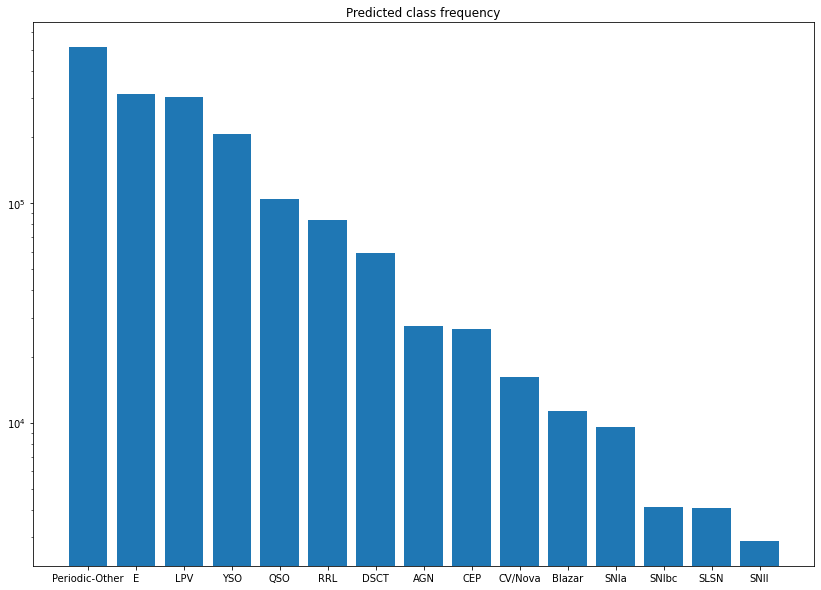

In [10]:
pred_classes_count = bhrf_predictions.groupby('class_name').count()['oid']
pred_classes_count = pred_classes_count.sort_values(ascending=False)
fig = plt.figure(figsize=(14, 10))
fig.patch.set_facecolor('white')
plt.bar(pred_classes_count.index.values, pred_classes_count.values)
plt.gca().set_yscale('log')
plt.title('Predicted class frequency')

## Spatial distribution of the predictions
### Galactic sources (LPV, CEP, YSO)

In [11]:
galactic_sources = bhrf_predictions[bhrf_predictions['class_name'].isin(
    ['LPV', 'CEP', 'YSO'])]
galactic_sources

,oid,classifier_name,classifier_version,class_name,probability,ranking
0,ZTF18aadcbyv,lc_classifier,hierarchical_rf_1.1.0,YSO,0.389424,1
4,ZTF18abgqdub,lc_classifier,hierarchical_rf_1.1.0,LPV,0.938432,1
5,ZTF18aaztgsd,lc_classifier,hierarchical_rf_1.1.0,LPV,0.503424,1
7,ZTF18abcswqt,lc_classifier,hierarchical_rf_1.1.0,LPV,0.301016,1
10,ZTF19abuawie,lc_classifier,hierarchical_rf_1.1.0,LPV,0.635712,1
...,...,...,...,...,...,...
1689369,ZTF18abdlbbd,lc_classifier,hierarchical_rf_1.1.0,LPV,0.829080,1
1689371,ZTF17aacpxez,lc_classifier,hierarchical_rf_1.1.0,YSO,0.640332,1
1689376,ZTF18aczbnfk,lc_classifier,hierarchical_rf_1.1.0,LPV,0.809508,1
1689379,ZTF18aacwdda,lc_classifier,hierarchical_rf_1.1.0,YSO,0.292752,1


In [12]:
# Heavy query (~ 8 min)
query = "select oid, name, value from feature where name = 'gal_l' or name = 'gal_b';"
features = pd.read_sql_query(query, conn)
features

,oid,name,value
0,ZTF19aargwjd,gal_b,4.166084
1,ZTF19aargwjd,gal_l,9.798493
2,ZTF20abmctuf,gal_b,-18.397648
3,ZTF20abmctuf,gal_l,86.174409
4,ZTF18abgsptz,gal_b,1.409847
...,...,...,...
3378659,ZTF18abxznqs,gal_b,-7.628971
3378660,ZTF18abxznqs,gal_l,81.512862
3378661,ZTF18acriibt,gal_b,-7.699532
3378662,ZTF18acriibt,gal_l,81.668100


In [13]:
gal_l = features[features.name == 'gal_l'].copy()
gal_l.rename(columns={'value': 'gal_l'}, inplace=True)
gal_l.drop(columns=['name'], inplace=True)
gal_l.set_index('oid', inplace=True)

gal_b = features[features.name == 'gal_b'].copy()
gal_b.rename(columns={'value': 'gal_b'}, inplace=True)
gal_b.drop(columns=['name'], inplace=True)
gal_b.set_index('oid', inplace=True)

coordinates = pd.concat([gal_l, gal_b], sort=True, axis=1)
coordinates

,gal_l,gal_b
oid,,
ZTF17aaaaaal,150.836443,-2.113660
ZTF17aaaaaam,151.324448,-2.308580
ZTF17aaaaaan,156.195091,-3.562309
ZTF17aaaaaao,156.135700,-3.847893
ZTF17aaaaaas,155.698153,0.933241
...,...,...
ZTF22aaikatd,113.252767,-3.684679
ZTF22aaikave,99.038002,-17.785965
ZTF22aaikbfm,109.889461,-9.358383


In [14]:
n_per_class = 1000  # sample size
replace = False  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, n_per_class, replace),:]
galactic_sources_subset = galactic_sources.groupby('class_name', as_index=False).apply(fn)
galactic_sources_subset = galactic_sources_subset.droplevel(level=0)
galactic_sources_subset


,oid,classifier_name,classifier_version,class_name,probability,ranking
1001485,ZTF18aaakipm,lc_classifier,hierarchical_rf_1.1.0,CEP,0.244080,1
594555,ZTF18abyroch,lc_classifier,hierarchical_rf_1.1.0,CEP,0.467360,1
362334,ZTF18abfguxl,lc_classifier,hierarchical_rf_1.1.0,CEP,0.269192,1
276247,ZTF18aayvbil,lc_classifier,hierarchical_rf_1.1.0,CEP,0.927144,1
1436644,ZTF19acenndk,lc_classifier,hierarchical_rf_1.1.0,CEP,0.214928,1
...,...,...,...,...,...,...
1026461,ZTF18aawcefj,lc_classifier,hierarchical_rf_1.1.0,YSO,0.354220,1
817388,ZTF18acvvrct,lc_classifier,hierarchical_rf_1.1.0,YSO,0.509184,1
464205,ZTF18abaqwjs,lc_classifier,hierarchical_rf_1.1.0,YSO,0.265016,1
16927,ZTF18acsodoq,lc_classifier,hierarchical_rf_1.1.0,YSO,0.199240,1


Text(0.5, 1.0, 'Spatial distribution of predictions: LPV, CEP, YSO')

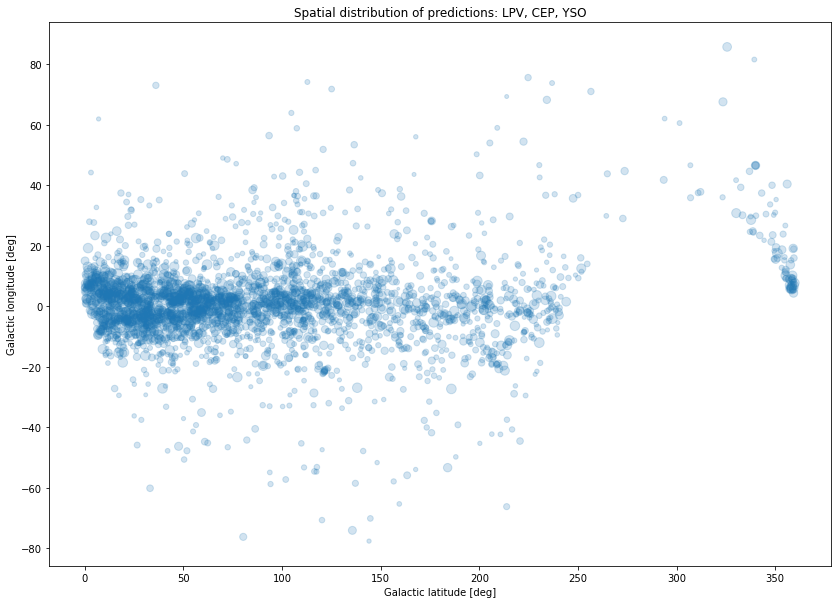

In [15]:
coordinates_subset = coordinates.loc[galactic_sources_subset.oid]
fig = plt.figure(figsize=(14, 10))
fig.patch.set_facecolor('white')
plt.scatter(
    coordinates_subset.values[:, 0],
    coordinates_subset.values[:, 1],
    alpha=0.2,
    s=galactic_sources_subset.probability*100
)
plt.xlabel('Galactic latitude [deg]')
plt.ylabel('Galactic longitude [deg]')
plt.title('Spatial distribution of predictions: LPV, CEP, YSO')

### Extragalactic sources (QSO, AGN, Blazar, SNe)

In [16]:
extragalactic_sources = bhrf_predictions[bhrf_predictions['class_name'].isin(
    ['QSO', 'Blazar', 'SNIa', 'SNII', 'AGN', 'SNIbc', 'SLSN'])]
extragalactic_sources

,oid,classifier_name,classifier_version,class_name,probability,ranking
9,ZTF19aaaicqh,lc_classifier,hierarchical_rf_1.1.0,Blazar,0.466528,1
12,ZTF20acvafso,lc_classifier,hierarchical_rf_1.1.0,Blazar,0.201312,1
13,ZTF22aacicie,lc_classifier,hierarchical_rf_1.1.0,QSO,0.736032,1
35,ZTF18aadcjyj,lc_classifier,hierarchical_rf_1.1.0,QSO,0.790400,1
36,ZTF18aadckcy,lc_classifier,hierarchical_rf_1.1.0,QSO,0.607376,1
...,...,...,...,...,...,...
1689281,ZTF18aadbual,lc_classifier,hierarchical_rf_1.1.0,QSO,0.584672,1
1689300,ZTF21abasoli,lc_classifier,hierarchical_rf_1.1.0,QSO,0.757248,1
1689315,ZTF19aawfkgw,lc_classifier,hierarchical_rf_1.1.0,QSO,0.534772,1
1689331,ZTF20acmghao,lc_classifier,hierarchical_rf_1.1.0,QSO,0.618488,1


In [17]:
n_per_class = 100  # sample size
replace = False  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, n_per_class, replace),:]
extragalactic_sources_subset = extragalactic_sources.groupby('class_name', as_index=False).apply(fn)
extragalactic_sources_subset = extragalactic_sources_subset.droplevel(level=0)
extragalactic_sources_subset

,oid,classifier_name,classifier_version,class_name,probability,ranking
1342794,ZTF19aasctre,lc_classifier,hierarchical_rf_1.1.0,AGN,0.701520,1
910162,ZTF19aaddgkz,lc_classifier,hierarchical_rf_1.1.0,AGN,0.171704,1
363169,ZTF18aarchxv,lc_classifier,hierarchical_rf_1.1.0,AGN,0.818064,1
1392889,ZTF19abegjnv,lc_classifier,hierarchical_rf_1.1.0,AGN,0.678832,1
1342209,ZTF21abdvbmm,lc_classifier,hierarchical_rf_1.1.0,AGN,0.243000,1
...,...,...,...,...,...,...
440056,ZTF21aagzfso,lc_classifier,hierarchical_rf_1.1.0,SNIbc,0.147920,1
1475277,ZTF20aaflaug,lc_classifier,hierarchical_rf_1.1.0,SNIbc,0.486000,1
1524881,ZTF20abqdqyh,lc_classifier,hierarchical_rf_1.1.0,SNIbc,0.374680,1
468289,ZTF18aavghvh,lc_classifier,hierarchical_rf_1.1.0,SNIbc,0.385440,1


Text(0.5, 1.0, 'Spatial distribution of extragalactic pred. sources')

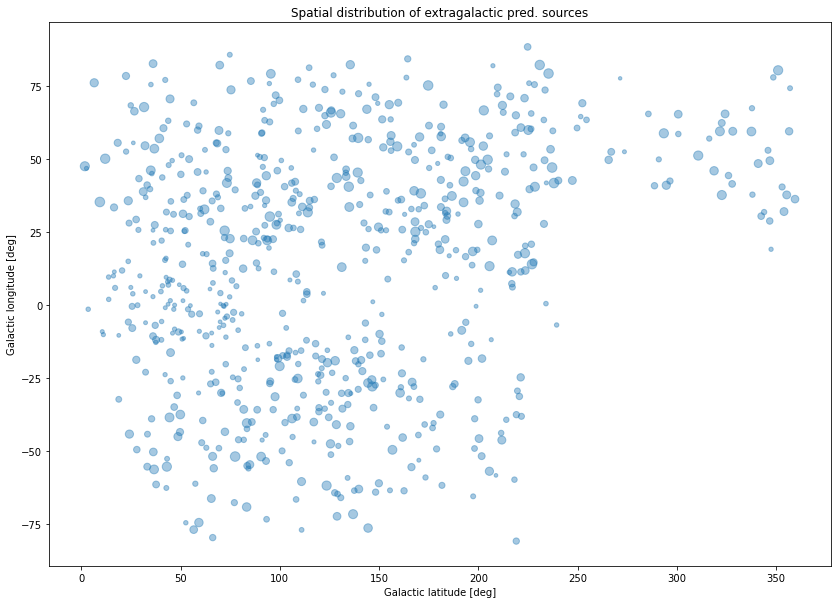

In [18]:
coordinates_subset = coordinates.loc[extragalactic_sources_subset.oid]
fig = plt.figure(figsize=(14, 10))
fig.patch.set_facecolor('white')
plt.scatter(
    coordinates_subset.values[:, 0],
    coordinates_subset.values[:, 1],
    alpha=0.4,
    s=extragalactic_sources_subset.probability*100
)
plt.xlabel('Galactic latitude [deg]')
plt.ylabel('Galactic longitude [deg]')
plt.title('Spatial distribution of extragalactic pred. sources')

## Visualizing a sample of predicted objects

In [19]:
n_per_class = 1  # sample size
minimum_probability = 0.3
replace = False  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, n_per_class, replace),:]
filtered_bhrf_predictions = bhrf_predictions[bhrf_predictions.probability >= minimum_probability]
sample_per_class = filtered_bhrf_predictions.groupby('class_name', as_index=False).apply(fn)
sample_per_class = sample_per_class.droplevel(level=0)
sample_per_class

,oid,classifier_name,classifier_version,class_name,probability,ranking
112551,ZTF21acapnyc,lc_classifier,hierarchical_rf_1.1.0,AGN,0.530460,1
300527,ZTF20aacxhjv,lc_classifier,hierarchical_rf_1.1.0,Blazar,0.467364,1
1653498,ZTF18abfclgy,lc_classifier,hierarchical_rf_1.1.0,CEP,0.334476,1
90224,ZTF18aagpyca,lc_classifier,hierarchical_rf_1.1.0,CV/Nova,0.482160,1
755402,ZTF18acsjmcb,lc_classifier,hierarchical_rf_1.1.0,DSCT,0.601032,1
994989,ZTF17aabwolv,lc_classifier,hierarchical_rf_1.1.0,E,0.768000,1
1137921,ZTF18ablqzxb,lc_classifier,hierarchical_rf_1.1.0,LPV,0.698896,1
346174,ZTF18acuwsqq,lc_classifier,hierarchical_rf_1.1.0,Periodic-Other,0.558108,1
725616,ZTF18acqtefr,lc_classifier,hierarchical_rf_1.1.0,QSO,0.413280,1
831956,ZTF18acwyjrj,lc_classifier,hierarchical_rf_1.1.0,RRL,0.938000,1


ValueError: num must be 1 <= num <= 16, not 17

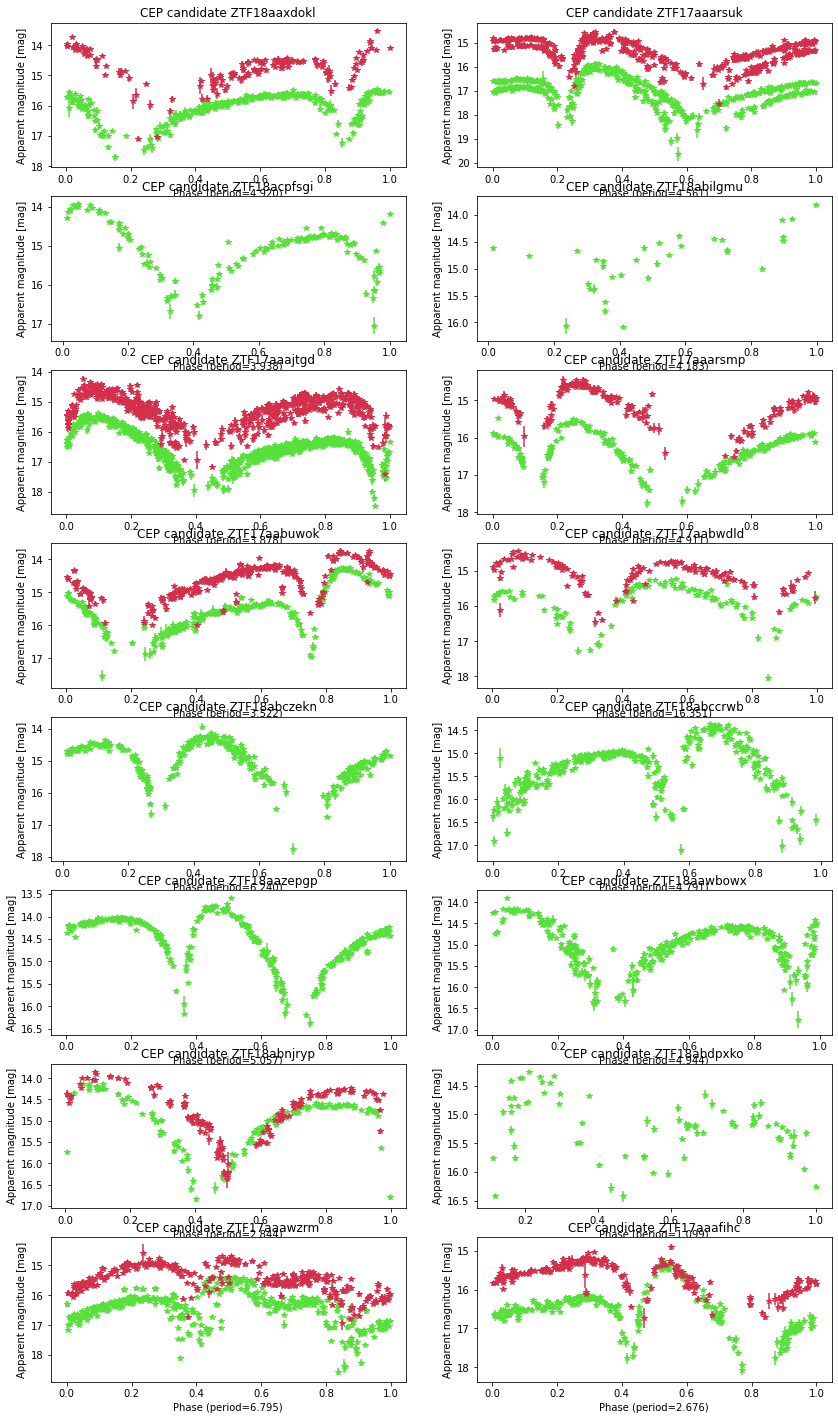

In [155]:
fig = plt.figure(figsize=(14, 25))
fig.patch.set_facecolor('white')
for index in range(len(sample_per_class)):
    astro_class = sample_per_class['class_name'].values[index]
    oid = sample_per_class['oid'].values[index]
    light_curve = alerce_client.query_detections(oid, format='pandas')
    plt.subplot(8, 2, index+1)
    period = None
    if astro_class in ['CEP', 'E', 'DSCT', 'LPV', 'Periodic-Other', 'RRL']:
        query = f"select oid, name, value from feature where name = 'Multiband_period' and oid = '{oid}';"
        period_df = pd.read_sql_query(query, conn)
        if len(period_df) > 0:
            period = float(period_df.value.values[0])
    plot_light_curve(light_curve, title=f'{astro_class} candidate {oid}', period=period)
plt.tight_layout()

In [146]:
class_name='CEP'
perOther=bhrf_predictions[bhrf_predictions['class_name']==class_name]

In [153]:
perOther[perOther['probability']>0.5]

,oid,classifier_name,classifier_version,class_name,probability,ranking
1735,ZTF18aazgeih,lc_classifier,hierarchical_rf_1.1.0,CEP,0.580860,1
2705,ZTF18aawbnkn,lc_classifier,hierarchical_rf_1.1.0,CEP,0.666540,1
2888,ZTF18aborpjm,lc_classifier,hierarchical_rf_1.1.0,CEP,0.790224,1
3077,ZTF18abaqyce,lc_classifier,hierarchical_rf_1.1.0,CEP,0.586976,1
4354,ZTF18aayedtk,lc_classifier,hierarchical_rf_1.1.0,CEP,0.556780,1
...,...,...,...,...,...,...
1685870,ZTF17aaafzcp,lc_classifier,hierarchical_rf_1.1.0,CEP,0.569088,1
1687350,ZTF18aasnlmo,lc_classifier,hierarchical_rf_1.1.0,CEP,0.817072,1
1687938,ZTF18abkcphu,lc_classifier,hierarchical_rf_1.1.0,CEP,0.551232,1
1688634,ZTF17aaassax,lc_classifier,hierarchical_rf_1.1.0,CEP,0.747296,1


In [143]:
n_per_class = 10000  # shistple size
minimum_probability = 0.6
maximum_probability=1
replace = False  # without replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, n_per_class, replace),:]
filtered_perOther = perOther[(perOther.probability >= minimum_probability) & (perOther.probability <= maximum_probability)]
sample_per_class = filtered_perOther.groupby('class_name', as_index=False).apply(fn)

sample_per_class = sample_per_class.droplevel(level=0)

ValueError: Cannot take a larger sample than population when 'replace=False'

ValueError: num must be 1 <= num <= 16, not 17

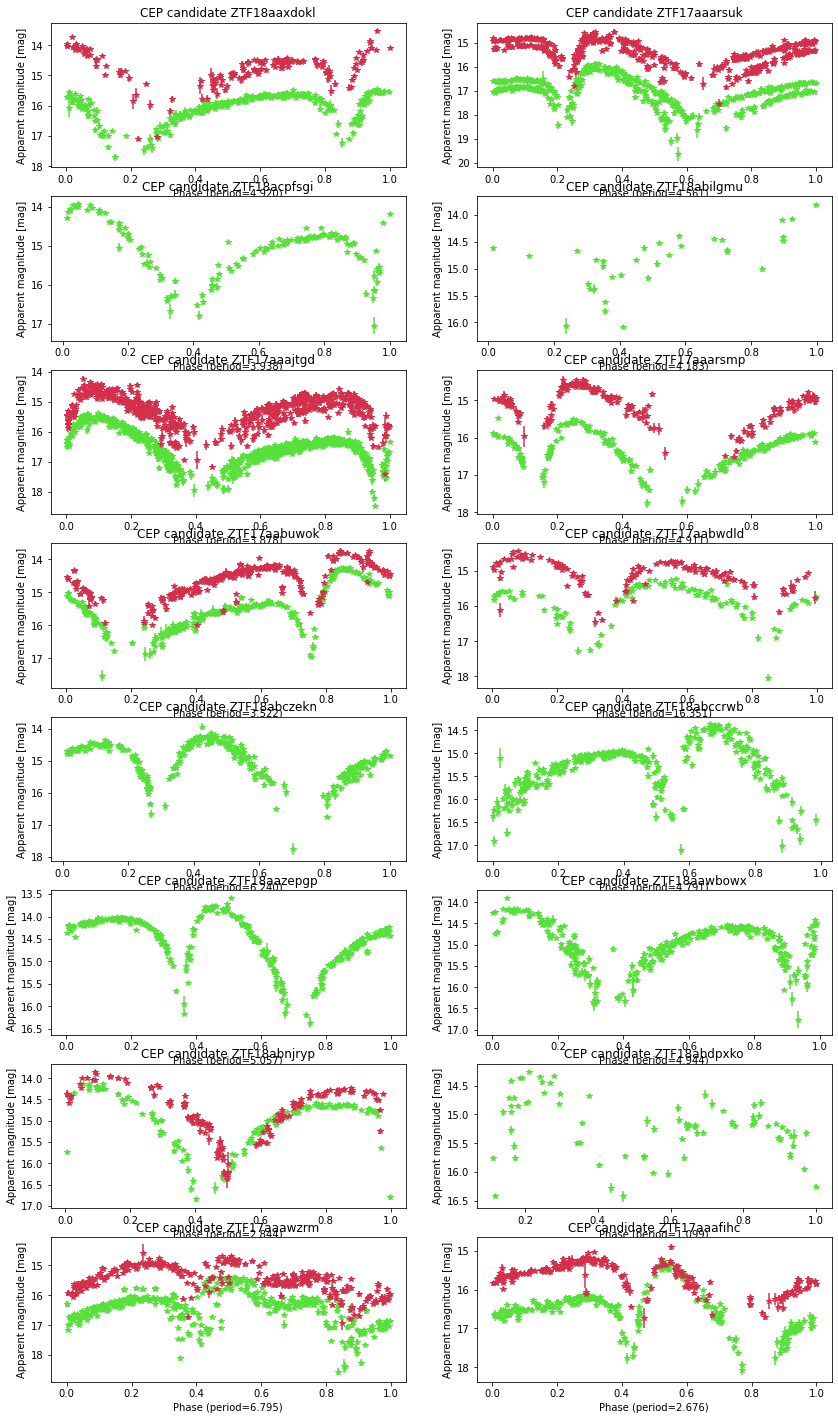

In [164]:
fig = plt.figure(figsize=(14, 25))
fig.patch.set_facecolor('white')
for index in range(len(sample_per_class)):
    astro_class = sample_per_class['class_name'].values[index]
    oid = sample_per_class['oid'].values[index]
    light_curve = alerce_client.query_detections(oid, format='pandas')
    plt.subplot(8, 2, index+1)
    period = None
    if astro_class ==class_name:
        query = f"select oid, name, value from feature where name = 'Multiband_period' and oid = '{oid}';"
        period_df = pd.read_sql_query(query, conn)
        if len(period_df) > 0:
            period = float(period_df.value.values[0])
    plot_light_curve(light_curve, title=f'{astro_class} candidate {oid}', period=period)
plt.tight_layout()

In [139]:
%%time
lc=alerce_client.query_lightcurve(oid)

CPU times: user 12.4 ms, sys: 0 ns, total: 12.4 ms
Wall time: 605 ms


In [141]:
%%time
for index in range(len(sample_per_class)):
    oid = sample_per_class['oid'].values[index]
    light_curve = alerce_client.query_detections(oid, format='pandas')

CPU times: user 1.47 s, sys: 0 ns, total: 1.47 s
Wall time: 1min 6s


In [163]:
sample_per_class['oid'].values(6)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
light_curve = alerce_client.query_detections(oid='', format='pandas')